# Setup

In [1]:
# REMOVE UNNECESSARY DEPENDENCIES BEFORE FINAL REPORT

# import dependencies
import pandas as pd
import numpy as np
import nltk
import re
import itertools
import matplotlib.pyplot as plt

## nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag

## sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

## joblib
from joblib import dump, load

##ensemble learning
from sklearn.ensemble import VotingClassifier

# set seed
np.random.seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# load data 
train = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Train.csv', header=0)
val = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Val.csv', header=0)

# REMOVE 'ID' FEATURE FROM DATASET? IS THE ML ALGORITHM BEING TRAINED ON THE 'ID'? IF SO, THIS IS USELESS NOISE THAT SHOULD BE REMOVED...
# SHOULD WE RELABEL THE 'TWEET' TO SOMETHING THAT MORE ACCURATELY REPRESENTS THE DATA, FOR EXAMPLE 'CLAIM' OR 'STATEMENT'? 'TWEET' MAY BE MISLEADING SINCE OUR DATA ISN'T ONLY COMPRISED OF TWEETS

In [3]:
print(len(train))
train.head()

6420


,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


# Pre-processing

In [4]:
# CONVERT "REAL" AND "FAKE" LABELS TO 0 AND 1 TO MAKE THEM MACHINE READABLE
# word_tokens = word_tokenize()
# ps = PorterStemmer() # creating an instance of PorterStemmer class

stop_words = set(stopwords.words("english")) # create list of stop words
def cleantext(string):
    text = string.lower().split() # convert letters to lowercase and split claims ('tweets') into separate words
    text = " ".join(text) # ???
    text = re.sub(r"http(\S)+",' ',text)    
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text) # replace '&' with ' and '
    text = text.replace('&amp',' ') # replace '&amp' with empty space
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text) # replace non-letters, non-numbers, & punctuation with empty space
    text = text.split() # ??? 
    #text = [ps.stem(word) for word in text] # set text equal to stemmed words
    text = [w for w in text if not w in stop_words] # remove stop words 
    text = " ".join(text) # joining the seperated pieces of string into one string
    return text

# apply cleantext() function to all tweets 
train['tweet'] = train['tweet'].map(lambda x: cleantext(x))
val['tweet'] = val['tweet'].map(lambda x: cleantext(x))
#test['tweet'] = test['tweet'].map(lambda x: cleantext(x))

# Feature Extraction


## Bag-of-Words (BoW)

In [5]:
# count vectorizer
cv = CountVectorizer() # count term frequency

# fit and transform train data to count vectorizer
cv.fit(train['tweet'].values)
cv_train = cv.transform(train['tweet'].values)

# fit and transform validation data to counter vectorizer
cv_val = cv.transform(val['tweet'].values)

## TF-IDF

In [6]:
# TF-IDF
tfidf = TfidfTransformer()

# fit the CountVector to TF-IDF transformer
tfidf.fit(cv_train)
tfidf_train = tfidf.transform(cv_train)

# do the same for the validation set
tfidf.fit(cv_val)
tfidf_val = tfidf.transform(cv_val)

## Word Embeddings

# Model Training

## #1 SVM

In [7]:
# SVM
svm_clf = LinearSVC() # classifier 
fit = svm_clf.fit(tfidf_train,train['label']) # train model

# make predictions
svm_pred = svm_clf.predict(tfidf_val)

## #2 Logistic Regression

In [8]:
# Logistic Regression
lr_clf = LogisticRegression() # classifier
fit = lr_clf.fit(tfidf_train,train['label']) # train model

# make predictions
lr_pred = lr_clf.predict(tfidf_val)

## #3 Extreme Gradient Boosting

In [9]:
# Gradient Boosting 
gb_clf = GradientBoostingClassifier() # classifier
fit = gb_clf.fit(tfidf_train,train['label']) # train model

# make predictions
gb_pred = gb_clf.predict(tfidf_val)

## #4 Adaptive Boosting

In [10]:
#adaboost
ada_clf = AdaBoostClassifier(n_estimators=500, random_state=0, learning_rate = 1.0) #classifier
fit = ada_clf.fit(tfidf_train,train['label']) #train model

#make prediction
ada_pred = ada_clf.predict(tfidf_val)

#next steps: using grid search to add and evaluate best tuning of n_estimator, depth, learning rates

## #5 Bidirectional Encoder Representations from Transformers 

In [11]:
# BERT

# make predictions

# Evaluation

In [19]:
# define print_metrics() function to print results
def print_metrics(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [20]:
# define plot_confusion_matrix() function to display results
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

[[ 963   57]
 [  80 1040]]
              precision    recall  f1-score   support

        fake       0.92      0.94      0.93      1020
        real       0.95      0.93      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140

Accuracy :  0.935981308411215
Precison :  0.9361483939370142
Recall :  0.935981308411215
F1 :  0.9359565193297956


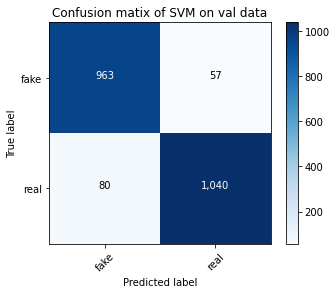

In [14]:
# SVM 
# display results
print_metrics(svm_pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],svm_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on val data')

[[ 957   63]
 [  95 1025]]
              precision    recall  f1-score   support

        fake       0.91      0.94      0.92      1020
        real       0.94      0.92      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140

Accuracy :  0.9261682242990654
Precison :  0.9265129977224534
Recall :  0.9261682242990654
F1 :  0.9261331076243714


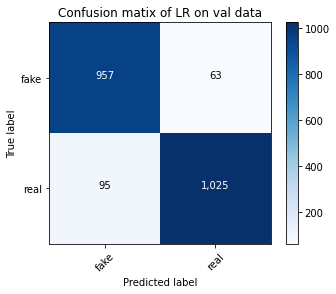

In [15]:
# Logistic Regression 
# display results
print_metrics(lr_pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],lr_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of LR on val data')

[[921  99]
 [179 941]]
              precision    recall  f1-score   support

        fake       0.84      0.90      0.87      1020
        real       0.90      0.84      0.87      1120

    accuracy                           0.87      2140
   macro avg       0.87      0.87      0.87      2140
weighted avg       0.87      0.87      0.87      2140

Accuracy :  0.8700934579439252
Precison :  0.8724397235529727
Recall :  0.8700934579439252
F1 :  0.8700480678174206


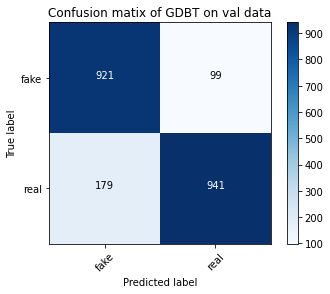

In [16]:
# Gradient Boosting 
# display results
print_metrics(gb_pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],gb_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of GDBT on val data')

In [17]:
# create a df of misclassified posts
val_orig = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Val.csv', header=0)
svm_val_misclass_df = val_orig[svm_pred!=val['label']]

# inspect df
svm_val_misclass_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 1 to 2138
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      137 non-null    int64 
 1   tweet   137 non-null    object
 2   label   137 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.3+ KB


XGBoost
val:
[[942  78]
 [163 957]]
              precision    recall  f1-score   support

        fake       0.85      0.92      0.89      1020
        real       0.92      0.85      0.89      1120

    accuracy                           0.89      2140
   macro avg       0.89      0.89      0.89      2140
weighted avg       0.89      0.89      0.89      2140

Accuracy :  0.8873831775700934
Precison :  0.8901264185580775
Recall :  0.8873831775700934
F1 :  0.8873518225383265


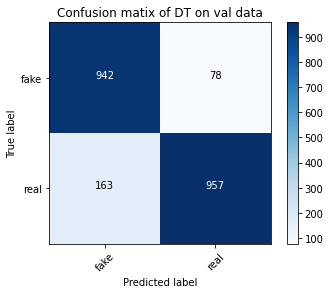

In [23]:
from xgboost import XGBClassifier
# XGBoost Classifier

# create pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', XGBClassifier(max_depth=10, min_child_weight=3)) # classifier
    ])

fit = pipeline.fit(train['tweet'],train['label']) # train model
print('XGBoost')
print ('val:')
pred = pipeline.predict(val['tweet']) # make predictions

# display results
print_metrics(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of DT on val data')

[[ 910  110]
 [  92 1028]]
              precision    recall  f1-score   support

        fake       0.91      0.89      0.90      1020
        real       0.90      0.92      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140

Accuracy :  0.905607476635514
Precison :  0.9058236472158957
Recall :  0.905607476635514
F1 :  0.9056513890199289


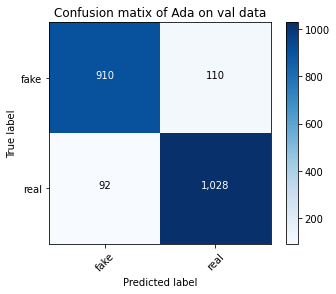

In [22]:
# Ada
#without hyperparameters: f1 = 0.8850370706902788
# display results
print_metrics(ada_pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],ada_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ada on val data')

# Set Up Ensemble Model

In [24]:
named_estimators = [
    ("SVM", svm_clf),
    ("Logistic Regression", lr_clf),
    ("Ada Boost", ada_clf),
    ("Gradient Boosting", gb_clf), # for each of the individual models
]

In [25]:
voting_clf = VotingClassifier(named_estimators)

In [26]:
voting_clf.fit(tfidf_train,train['label'])

VotingClassifier(estimators=[('SVM', LinearSVC()),
                             ('Logistic Regression', LogisticRegression()),
                             ('Ada Boost',
                              AdaBoostClassifier(n_estimators=500,
                                                 random_state=0)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier())])

In [28]:
voting_pred = voting_clf.predict(tfidf_val)

In [36]:
#soft voting (predicts the class label based on the argmax of the sums of the predicted probabilities)
voting_clf.voting = "soft"

[[ 972   48]
 [ 113 1007]]
              precision    recall  f1-score   support

        fake       0.90      0.95      0.92      1020
        real       0.95      0.90      0.93      1120

    accuracy                           0.92      2140
   macro avg       0.93      0.93      0.92      2140
weighted avg       0.93      0.92      0.92      2140

Accuracy :  0.9247663551401869
Precison :  0.9264015010209692
Recall :  0.9247663551401869
F1 :  0.924728971452294


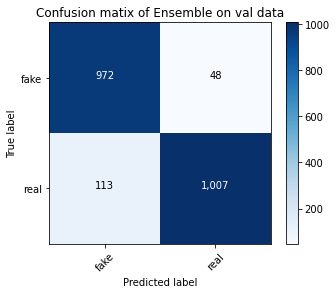

In [44]:
print_metrics(voting_pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],voting_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ensemble on val data')

So far, simple SVM outfperforms ensemble learning

#Error Analysis

In [59]:
#error analysis, to compair the false classifications of the different models

false_pred_svm = val[(val["label"] != svm_pred)]
false_pred_gb = val[(val["label"] != gb_pred)]
false_pred_lr = val[(val["label"] != lr_pred)]
false_pred_xg = val[(val["label"] != pred)]
false_pred_ada = val[(val["label"] != ada_pred)]
false_pred_ensemble = val[(val["label"] != voting_pred)]

#common_mistakes = false_pred_svm = false_pred_gb = false_pred_lr = false_pred_xg = false_pred_ada = false_pred_ensemble
print(false_pred_ensemble)



        id                                              tweet label
1        2  11 13 people diamond princess cruise ship inti...  fake
10      11  still fly friendly skies without fear covid ai...  real
13      14  tomorrow april 6 pass 10000 coronavirus deaths...  real
25      26  breathlessness excessive fatigue muscle aches ...  real
28      29  everyone help prevent spread covid19 clara cor...  real
...    ...                                                ...   ...
2051  2052  missouri businesses open monday may 4 new orde...  fake
2079  2080  coronavirus sir keir starmer says second lockd...  real
2090  2091  uk government says responded well coronavirus ...  real
2104  2105  june 26 taipei veterans general hospital imple...  fake
2107  2108  icymi deborah birx 3 8 20 white house briefing...  real

[161 rows x 3 columns]


In [61]:
#print(common_mistakes)
common_mistakes = pd.merge(false_pred_svm, false_pred_ada, on=['tweet'], how='inner')
print(common_mistakes)
common_mistakes.to_csv('/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/error_analysis/common_mistakes.csv', encoding='utf-8')

    id_x                                              tweet label_x  id_y  \
0      2  11 13 people diamond princess cruise ship inti...    fake     2   
1     11  still fly friendly skies without fear covid ai...    real    11   
2     14  tomorrow april 6 pass 10000 coronavirus deaths...    real    14   
3     56  india 3 covid19vaccine trials underway dcgi pe...    real    56   
4     56  india 3 covid19vaccine trials underway dcgi pe...    real   274   
..   ...                                                ...     ...   ...   
87  2018  u nears 2 7 million total covid 19 cases 13000...    fake  2018   
88  2044  kids covid contagious adults methodsmanmd expl...    real  2044   
89  2059  wwn brings groundbreaking reportage government...    fake  2059   
90  2080  coronavirus sir keir starmer says second lockd...    real  2080   
91  2105  june 26 taipei veterans general hospital imple...    fake  2105   

   label_y  
0     fake  
1     real  
2     real  
3     real  
4     real

In [62]:
#mount drive to save data
from google.colab import drive
drive.mount('drive')

Mounted at drive
